### Purpose

This demo will walk through the analysis of Kalman filtering a true signal.

The regime is:

- *Imperfect*: projection of true frequency components on the Kalman basis is impossible
- *Undersampled*: even if perfect projection was possible, the Kalman filter basis can only see 1 in every 500 true frequency components
- *Unaliased Computationally*: the max frequency in the Kalman basis is greater than the max true frequency component
- *Unaliased Physically*: the Experimental sampling rate much larger than the true bandwidth of the true signal
- *Low noise*: Noise is 1% of "3*standard deviation" of our true signal - our true signal is a random sample of the true theoretical PSD for an erogdic stationary process, and hence all time domain points will be within 3 standard deviations of the mean (zero). This is just a consistent way of defining measurement noise strength for any test case.

### Loading Parameters

In this section, I load parameters defining the Experiment, Optimisation Procedure, Kalman Design, and the Truth (which the algorithm is blind to). 

In [2]:
import numpy as np

########################
# File Data
########################
filename0_ = 'demo4'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 50
num_randparams_ = 50
space_size_ = np.arange(-8,3)
truncation_ = 20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 50
n_testbefore_ = 50
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters - Test Case 4 Variation 1 (Imperfect Learning, Undersampling)
########################

apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 2.0*(4.0/3.0)*4.0*10**(-4)
p_ = -1 #1 #-2 #-1 #0.0
J_ = int((1.0/2.0)*(3.0/4.0)*10**5)
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 50

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


Now, I load a Kalman Experiment. I will perform a basic check that the code is working correctly by plotting Kalman Filter (fast), Kalman Filter 2 (standard) and Detailed Kalman Filter on the same plot. We know there is a disparity between detailed and fast Kalman filtering, and this will show up below in both the time domain  forecasts and the frequency domain learned amplitudes.

Further, the  filter is untuned - expect things to look bad.

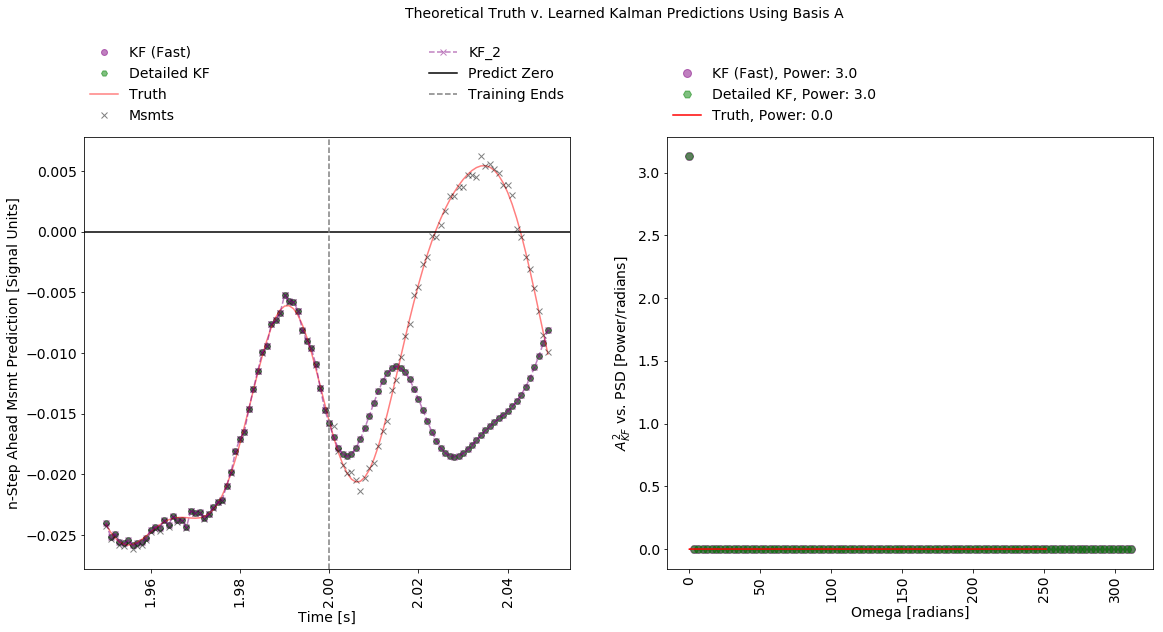

('My initial sigma, R =', 0.1, 0.1)


In [15]:
from ML_Risk import Create_KF_Experiment

Test_Object_4 = Create_KF_Experiment(bayes_params_, filename0_, savetopath_, max_it_, exp_params_, kalman_params_, 
                                    msmt_noise_params_, true_noise_params_, 
                                    user_defined_variance=None, skip_msmts=skip)

Test_Object_4.run_test_KF()
print('My initial sigma, R =', Test_Object_4.optimal_sigma, Test_Object_4.optimal_R)

Aside from the poor predictions (and the inaccurate rounding of total power), true noise PSD doesn't look right. Let's check it:

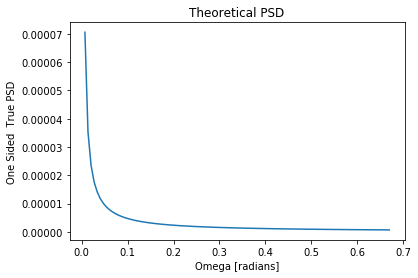

('Power (unrounded)', 0.0015676703229580999)


In [87]:
Test_Object_4.beta_z_truePSD() # call it again just to be on the safe side
import matplotlib.pyplot as plt
zoom_in= Test_Object_4.J + 100
plt.figure()
plt.title('Theoretical PSD')
plt.xlabel('Omega [radians]')
plt.ylabel('One Sided  True PSD')
plt.plot(Test_Object_4.true_w_axis[Test_Object_4.J:zoom_in], Test_Object_4.true_S_twosided[Test_Object_4.J:zoom_in])
plt.show()

print("Power (unrounded)", Test_Object_4.true_S_norm)

So, the true noise PSD has extremely low values for the parameters chosen. 

Further, the filter failed at learning the spectrum and gave a lot of weight to zero frequency.

Let's try to optimise:

In [16]:
Test_Object_4.naive_implementation()
Test_Object_4.get_tuned_params() #extracts lowest risk parameters during training 
Test_Object_4.set_tuned_params() #sets Sigma, R to be the newly found optimal parameters

Time Taken for BR Map:  14161.6945438
Optimal params fore prediction and forecasting [  4.45248804e-05   7.93285197e-08] [  3.85926870e-05   8.34472543e-08]


The printed output above shows that the paramters which minimise losses during *training* are not always the same as the parameters which minimise losses during *forecasting* n-steps ahead. However, we hope that optimal parameters in both situations are "close by".

We will now formally examine the Bayes Risk as a function of random choices of Sigma and R. We can choose two loss functions - one step ahead prediction losses during training, and/or n-step ahead forecasting losses post-training.

We examine the (sigma, R) pair that gives us the lowest Bayes Risk during *training*. This is marked with a purple X below. 

Optimal params [  4.45248804e-05   7.93285197e-08] [ 0.05682651  0.61965168]
Prediction
Loss Minimising Point Index: 8
Optimal Hyper Parameters:  [  4.45248804e-05   7.93285197e-08]
Loss Value 9.05409647415e-08
Forecasting
Loss Minimising Point Index: 22
Optimal Hyper Parameters:  [ 0.05682651  0.61965168]
Loss Value 0.000132226700609


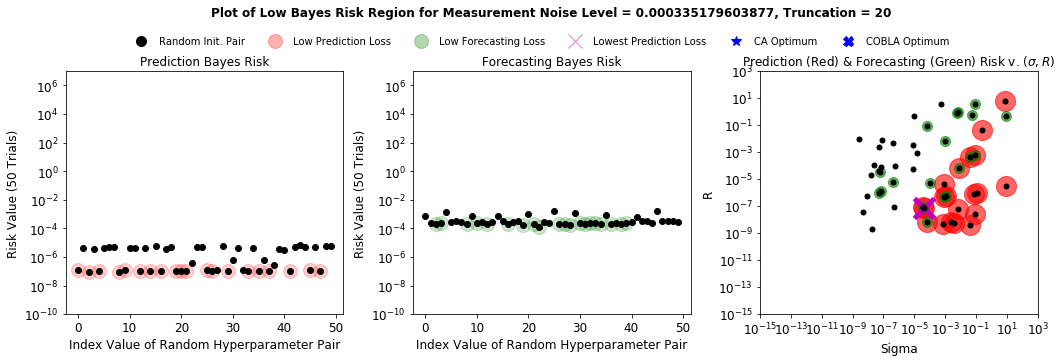

In [18]:
from plot_BR import Plot_BR_Results
filename_and_path_BR_4 = './'+str(Test_Object_4.filename_BR)+'.npz'
plotter_BR_4 = Plot_BR_Results(filename_and_path_BR_4)
plotter_BR_4.make_plot()

Here, we note that the red and green dots overlap in the last plot and the purple X lies within this overlap region. Why does this matter?

Optimisation is not always sensible in pathological regimes. We do not have a theoretical way of predicting that optimisation makes sense in an undersampled, imperfect learning environment. 

An overlap of red and green dots means that parameters for lowest bayes risk during training could  give us low loss during forecasting. It suggests that optimisation could be sensible to attempt. The purple X marks the lowest Bayes Risk during training. It lies within the overlap region which suggests that it's not a numerical artefact but could be interpreted as "tuning a filter".

Now, we create many Kalman predictions on different realisations of truth and noisy data, but we can use a tuned filter. Can we beat prediciting the mean (i.e. predict zero)?

We plot an ensemble average of 50 Kalman Filering runs below. 

The first figure shows that we beat predicting the mean of the noise for 5- 7 steps ahead, on average, over 50 different "truths" from the true PSD and a new "noisy" data set for each truth realisation.

The second figure shows that prediction in  single run could look super lame. 

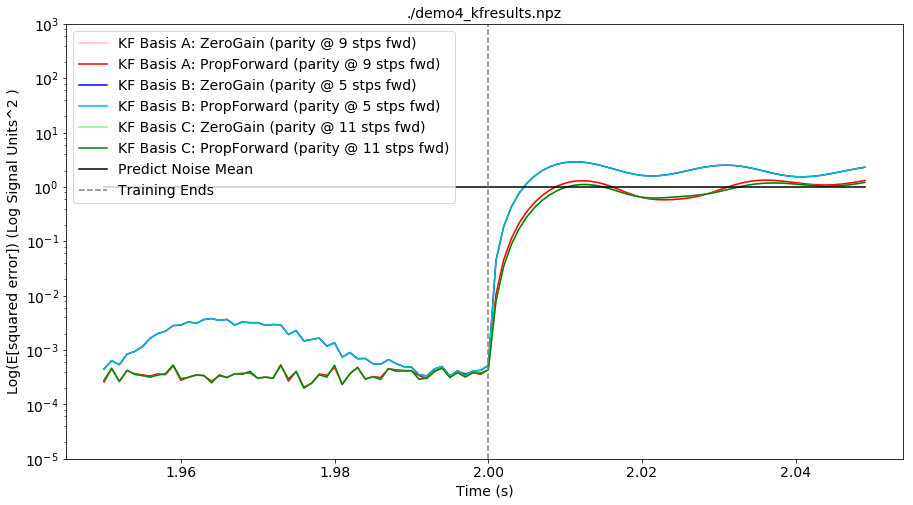

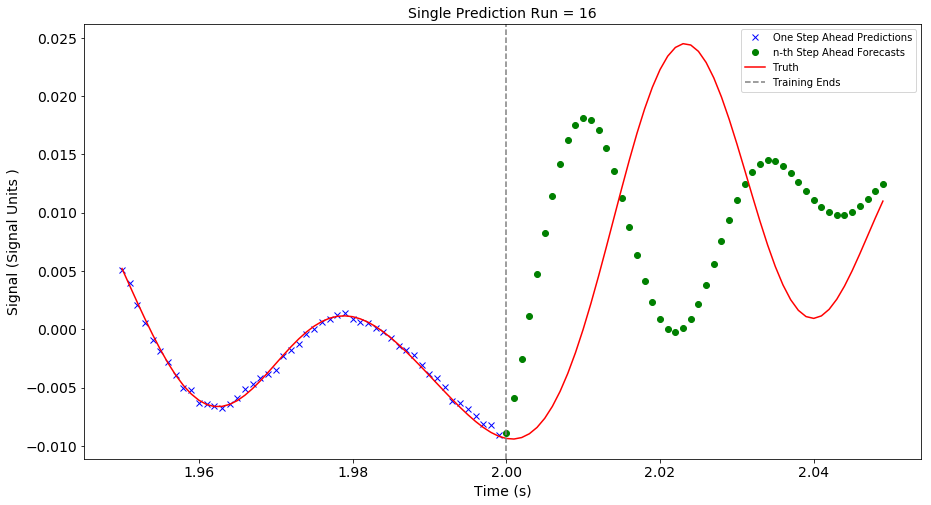

In [19]:
from plot_KF import Plot_KF_Results
Test_Object_4.ensemble_avg_predictions()
filename_and_path_KF_4 = './'+str(Test_Object_4.filename_KF)+'.npz'
plotter_KF_4 = Plot_KF_Results(exp_params_, filename_and_path_KF_4)
plotter_KF_4.make_plot()
plotter_KF_4.show_one_prediction()

To double-check, let's return to make sure that the underlying code is working properly and that different flavors of the Kalman filter are converging on a common result. Here the fast Kalman filter (purple) and the detailed Kalman filter (green) are pretty close but not the same.

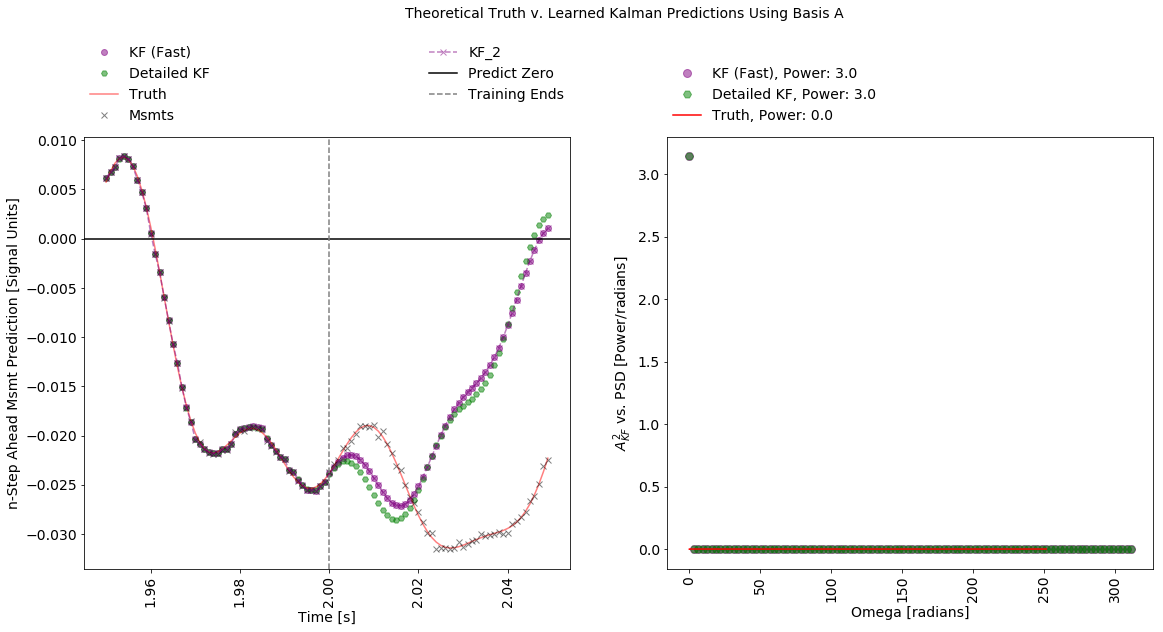

In [21]:
Test_Object_4.run_test_KF()

However, the Kalman learned amplitudes still don't look right. Let's examine further using the Detailed Kalman Filter to extract learned amplitudes

In [30]:
truth, signal = Test_Object_4.generate_data_from_truth(None)
prediction, amps = Test_Object_4.single_prediction(signal, use_skf_amp='Yes')

First, let's check the value of the amplitudes for zero frequency basis osccilator (amplitude is super large) and the next ten osscilators (amplitudes are super low):

In [44]:
print amps[0:10]

[  9.99943999e-01   4.67084242e-03   2.35760407e-03   4.30094879e-03
   4.21450312e-03   3.17782444e-03   3.72519723e-03   6.65778415e-04
   2.77471221e-03   1.55129955e-03]


We can plot this, leaving the zero frequency value out (it's large), and check if the learned amplitudes have roughly, a 1/f shape (they do, but barely):

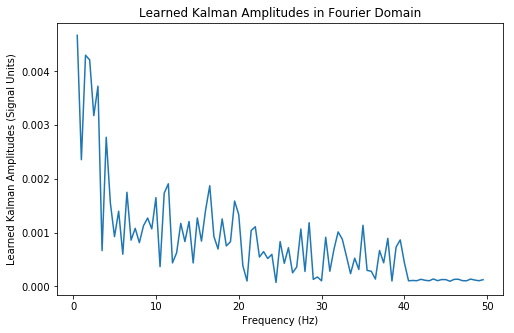

In [84]:
plt.figure(figsize=(8,5))
plt.title('Learned Kalman Amplitudes in Fourier Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Learned Kalman Amplitudes (Signal Units)')
plt.plot(Test_Object_4.basisA[1:], amps[1:])
plt.show()

Now let's plot the true PSD. I will also plot the PSD estimate, obtained from squaring the Learned Amplitudes from one run.

The figure below suggests that choice of true PSD to model "undersampling" was poor - the true values are so low in amplitudes that they are probably getting dwarfed by numerical noise in the filtering run. So I need to choose parameter regimes for undersampling (and other) cases more carefully.

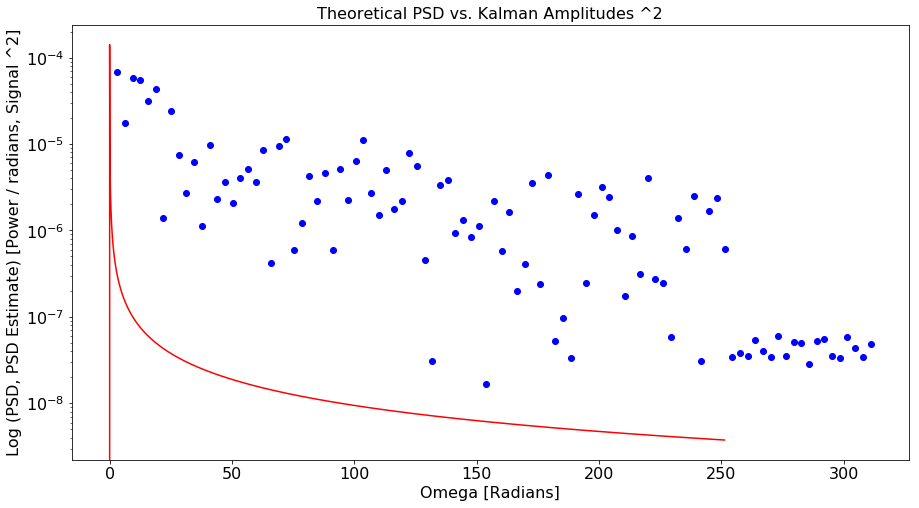

('Power (unrounded)', 0.0015676703229580999)
('Power (unrounded)', 3.141736711425223)


In [80]:
omega, psd_estimate = Test_Object_4.convert_amp_hz_to_radians(Test_Object_4.basisA, amps)
#zoom_in= Test_Object_4.J + 100
plt.figure(figsize=(15,8))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
ax.set_title('Theoretical PSD vs. Kalman Amplitudes ^2')
ax.set_xlabel('Omega [Radians]')
ax.set_ylabel('Log (PSD, PSD Estimate) [Power / radians, Signal ^2]')
ax.set_yscale('log')
ax.plot(omega[1:], psd_estimate[1:], 'bo')
ax.plot(Test_Object_4.true_w_axis[Test_Object_4.J-1:], 2.0*Test_Object_4.true_S_twosided[Test_Object_4.J-1:],'r')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                        item.set_fontsize(16)
plt.show()


print("Power (unrounded)", Test_Object_4.true_S_norm)
print("Power (unrounded)", np.sum(psd_estimate))

As a spectrum of learned amplitudes, this doesn't look great. However, we don't expect the filter to perform well in undersampled, imperfect learning environment.  

Is there any good news?

Maybe:
- Learned PSD estimate has a shape that appears to follow 1/f noise
- Amplitudes^2 drop at the band edge of the true noise